In [ ]:
import numpy as np
import random
import pandas as pd
import time
import matplotlib.pyplot as plt
import copy
import itertools
from scipy.optimize import minimize
from scipy import linalg
import math

In [ ]:


def featuremap(context,action):
    c = context
    a = action
    phi = np.array([a[0]**2,a[1]**2,a[2]**2,a[3]**2,a[4]**2,c[0]**2,c[1]**2,c[2]**2,c[3]**2,c[4]**2,c[0]*a[0],c[1]*a[1],c[2]*a[2],c[3]*a[3],c[4]*a[4]],ndmin=2)
    return phi


In [ ]:
def parameters_chat_given_gamma (gamma, parameters):
    var_contextnoise = parameters[4]
    var_contextdist = parameters [1]
    mean_contextdist =parameters[0]
    var_noise_inv = np.linalg.inv(var_contextnoise)
    var_context_inv = np.linalg.inv(var_contextdist)
    M = var_noise_inv+var_context_inv
    M_inv = np.linalg.inv(M)
    G = var_noise_inv- var_noise_inv.dot(np.linalg.inv(M).T).dot(var_noise_inv)
    G_term2=var_noise_inv.dot(np.linalg.inv(M).T).dot(var_noise_inv)
    #F = np.linalg.inv(G).T.dot(G.T.dot(gamma)+ G_term2.T.dot(mean_contextdist))
    F= np.linalg.inv(G).T.dot(G.dot(gamma)+var_noise_inv.dot(M_inv.T).dot(var_context_inv).dot(mean_contextdist))
    output = (F, np.linalg.inv(G))
    return output


def parameters_gamma_given_contexthist(contexthist, ind,parameters):
    # contexthist is a numpy array with rows corresponding to past observed contexts
    var_contextnoise = parameters[4]
    var_contextdist = parameters [1]
    var_contextnoise_prior = parameters[3]
    mean_contextdist =parameters[0]
    length = contexthist.shape[0]
    var_noise_inv = np.linalg.inv(var_contextnoise)
    var_context_inv = np.linalg.inv(var_contextdist)
    M = var_noise_inv+var_context_inv
    M_inv = np.linalg.inv(M)
    G = var_noise_inv- var_noise_inv.dot(np.linalg.inv(M).T).dot(var_noise_inv)
    G_inv = np.linalg.inv(G)
    N = np.linalg.inv(var_contextnoise_prior)+G* length
    N_inv = np.linalg.inv(N)
    if ind == 0:
        contexthist = np.array(contexthist,ndmin=2)
    else:
        contexthist = contexthist
    add = np.sum(contexthist,axis = 0)

    c= (mean_contextdist.T.dot(var_context_inv).dot(M_inv.T).dot(var_noise_inv)).T*length
    tilde_M = N_inv.T.dot(G.dot(add)-length*var_noise_inv.dot(M_inv.T).dot(var_context_inv).dot(mean_contextdist))
    #a = var_noise_inv+ var_noise_inv.dot(M_inv.T).dot(var_noise_inv)
    #b = G_inv.dot(G_inv).dot(G_inv.T)
    #add = np.sum(contexthist,axis = 0)
    #d = (add.T.dot(G_inv).dot(G_inv.T).dot(var_noise_inv)).T
    #tilde_M = N_inv.T.dot(a.dot(b).dot(c)+a.dot(d))
    output = (tilde_M, N_inv)
    return output

def predicted_context(contexthist,chat,ind,parameters):
    var_contextnoise = parameters[4]
    mean_contextnoise_prior = parameters[2]
    var_contextdist = parameters [1]
    var_contextnoise_prior = parameters[3]
    mean_contextdist =parameters[0]
    params = parameters_gamma_given_contexthist(contexthist,ind,parameters)
    if ind == 1:
        tilde_M = params[0]
        N = np.linalg.inv(params[1])
        var_noise_inv = np.linalg.inv(var_contextnoise)
        var_context_inv = np.linalg.inv(var_contextdist)
        M = var_noise_inv+var_context_inv
        M_inv = np.linalg.inv(M)
        H = var_noise_inv.dot(M_inv.T).dot(var_noise_inv)+N
        H_inv = np.linalg.inv(H)
        D = (M_inv.T).dot(var_context_inv).dot(mean_contextdist)
        E = (M_inv.T).dot(var_noise_inv).dot(chat)
        L = (D+E).T.dot(var_noise_inv)+tilde_M.T.dot(N)
        R = M - var_noise_inv.dot(H_inv.T).dot(var_noise_inv)
        R_inv = np.linalg.inv(R)
        V = R_inv.T.dot(M.dot(D+E)-var_noise_inv.dot(H_inv.T).dot(L.T))
    else:
        tilde_M = mean_contextnoise_prior
        N = var_contextnoise_prior
        var_noise_inv = np.linalg.inv(var_contextnoise)
        var_context_inv = np.linalg.inv(var_contextdist)
        M = var_noise_inv+var_context_inv
        M_inv = np.linalg.inv(M)
        H = var_noise_inv.dot(M_inv.T).dot(var_noise_inv)+N
        H_inv = np.linalg.inv(H)
        D = (M_inv.T).dot(var_context_inv).dot(mean_contextdist)
        E = (M_inv.T).dot(var_noise_inv).dot(chat)
        L = (D+E).T.dot(var_noise_inv)+tilde_M.T.dot(N)
        R = M - var_noise_inv.dot(H_inv.T).dot(var_noise_inv)
        R_inv = np.linalg.inv(R)
        V = R_inv.T.dot(M.dot(D+E)-var_noise_inv.dot(H_inv.T).dot(L.T))
    output =(V, R_inv)
    return output

def expected_featuremap(action,predictedcontext_parameters):
    a = action
    m = predictedcontext_parameters[0] #mean vector
    var = predictedcontext_parameters[1] # variance
    c_sq =[var[0][0]+m[0]**2, var[1][1]+m[1]**2,var[2][2]+m[2]**2, var[3][3]+m[3]**2, var[4][4]+m[4]**2]
    phi = np.array([a[0]**2,a[1]**2,a[2]**2,a[3]**2,a[4]**2,c_sq[0],c_sq[1],c_sq[2],c_sq[3],c_sq[4],m[0]*a[0],m[1]*a[1],m[2]*a[2],m[3]*a[3],m[4]*a[4]],ndmin=2)
    return phi

def predicted_rewardparameter(avg_featurehist,rewardhist,parameters):
    reward_noise_var = parameters[9]
    var_theta = parameters[7]
    add_1 = np.zeros(15)
    add_2 = np.zeros((15,15))

    for i in range(avg_featurehist.shape[0]):
        phi_ac = np.array(avg_featurehist[i],ndmin=2)
        phi_matrix = phi_ac.T.dot(phi_ac)
        add_1 = add_1 + rewardhist[i]*phi_ac[0]
        add_2 = add_2 + phi_matrix
    V = np.linalg.inv(var_theta)+add_2/reward_noise_var
    min_eig = np.min(np.real(np.linalg.eigvals(V)))
    if min_eig < 0:
        V -= 1e-12 * np.eye(*V.shape)

    V_inv = np.linalg.inv(V)
    mean = V_inv.T.dot(add_1)/reward_noise_var
    output = (mean, V_inv)
    return output

def parameters_inverselikelihood(chat,gamma,parameters):
    var_contextnoise = parameters[4]
    var_contextdist = parameters [1]
    mean_contextdist =parameters[0]
    var_noise_inv = np.linalg.inv(var_contextnoise)
    var_context_inv = np.linalg.inv(var_contextdist)
    M = var_noise_inv+var_context_inv
    M_inv = np.linalg.inv(M)
    A = M_inv.T.dot(var_context_inv.dot(mean_contextdist)+var_noise_inv.dot((chat-gamma)))
    output = (A, M_inv)
    return output



def action_choice(theta,actions,predictedcontext_parameters):
    dummy = np.zeros(actions.shape[0])
    for i in range(actions.shape[0]):
        dummy[i] = expected_featuremap(actions[i],predictedcontext_parameters).dot(theta)
    max_value = np.max(dummy)
    index = np.argmax(dummy)
    action = actions[index]
    return action

def action_choice_noisy(theta,context,actions):
    dummy = np.zeros(actions.shape[0])
    for i in range(actions.shape[0]):
        dummy[i] = featuremap(context, actions[i]).dot(theta)
    max_value = np.max(dummy)
    index = np.argmax(dummy)
    action = actions[index]

    return action

def predicted_rewardparameter_noisy(contexthist,rewardhist,actionhist,parameters):
    reward_noise_var = parameters[9]
    var_theta = parameters[7]
    add_1 = np.zeros(15)
    add_2 = np.zeros((15,15))

    for i in range(contexthist.shape[0]):
        phi_ac = featuremap(contexthist[i],actionhist[i])
        phi_matrix = phi_ac.T.dot(phi_ac)
        add_1 = add_1 + rewardhist[i]*phi_ac[0]
        add_2 = add_2 + phi_matrix
    V = np.linalg.inv(var_theta)+add_2/reward_noise_var
    min_eig = np.min(np.real(np.linalg.eigvals(V)))
    if min_eig < 0:
        V -= 1e-12 * np.eye(*V.shape)

    V_inv = np.linalg.inv(V)
    mean = V_inv.T.dot(add_1)/reward_noise_var
    output = (mean, V_inv)
    return output

def is_pos_semidef(x):
    return np.all(np.linalg.eigh(x)>= 0)

In [ ]:
def doubleThompsonSampling_denoising(num_iters,theta_seed,gamma_seed,parameters,context_list,noisycontext_list):
    #unpacking parameter values
    mean_contextdist =parameters[0]
    var_contextdist = parameters [1]
    mean_contextnoise_prior = parameters[2]
    var_contextnoise_prior = parameters[3]
    var_contextnoise = parameters[4]
    actions = parameters[5]
    mean_theta = parameters[6]
    var_theta = parameters[7]
    reward_noise_mean = parameters[8]
    reward_noise_var = parameters[9]
    #setting true values theta_true and gamma_true
    np.random.seed(theta_seed)
    theta_true = np.random.multivariate_normal(mean_theta, var_theta) #sample from prior distribution
    np.random.seed(gamma_seed)
    gamma_true = np.random.multivariate_normal(mean_contextnoise_prior, var_contextnoise_prior)
    contexthist = np.zeros((num_iters,dim_context))
    rewardhist = np.zeros(num_iters)
    actionhist = np.zeros((num_iters, dim_action))
    optimalactionhist = np.zeros((num_iters, dim_action))
    avg_featurehist =np.zeros((num_iters,15))
    per_step_regret = np.zeros(num_iters)
    cum_regrets = np.zeros(num_iters)
    for t in range(num_iters):
        if t==0:
            #np.random.seed(5)
            theta_sampled = np.random.multivariate_normal(mean_theta, var_theta)

            #context_true = np.random.multivariate_normal(mean_contextdist, var_contextdist) # true context
            #context_noisy = np.random.multivariate_normal(context_true+gamma_true,var_contextnoise)#sample noisy context
            context_true = context_list[t]
            context_noisy = noisycontext_list[t]
            predictedcontext_parameters = predicted_context(contexthist[0],context_noisy,0,parameters)
            action_TS = action_choice(theta_sampled,actions,predictedcontext_parameters)
            inverselikelihood_parameters_oracle = parameters_inverselikelihood(context_noisy,gamma_true,parameters)
            action_optimal_oracle = action_choice(theta_true,actions,inverselikelihood_parameters_oracle)
            mean_reward = featuremap(context_true,action_TS).dot(theta_true)
            reward_observed = np.random.normal(mean_reward, reward_noise_var)
            avg_feature = expected_featuremap(action_TS,predictedcontext_parameters)
            avg_featurehist[t] =avg_feature
            contexthist[t] = context_noisy
            rewardhist[t] = reward_observed
            actionhist[t] = action_TS
            per_step_regret[t] = expected_featuremap(action_optimal_oracle,inverselikelihood_parameters_oracle).dot(theta_true)-expected_featuremap(action_TS,inverselikelihood_parameters_oracle).dot(theta_true)
            cum_regrets[t] = per_step_regret[t]


        else:
            theta_star_distparameters = predicted_rewardparameter(avg_featurehist[0:t], rewardhist[0:t],parameters)
            theta_sampled = np.random.multivariate_normal(theta_star_distparameters[0], theta_star_distparameters[1])
            #context_true = np.random.multivariate_normal(mean_contextdist, var_contextdist) # true context
            #context_noisy = np.random.multivariate_normal(context_true+gamma_true,var_contextnoise)
            context_true = context_list[t]
            context_noisy = noisycontext_list[t]
            predictedcontext_parameters = predicted_context(contexthist[0:t],context_noisy,1,parameters)
            action_TS = action_choice(theta_sampled,actions,predictedcontext_parameters)
            inverselikelihood_parameters_oracle = parameters_inverselikelihood(context_noisy,gamma_true,parameters)
            action_optimal_oracle = action_choice(theta_true,actions,inverselikelihood_parameters_oracle)
            mean_reward = featuremap(context_true,action_TS).dot(theta_true)
            reward_observed = np.random.normal(mean_reward, reward_noise_var)
            avg_feature = expected_featuremap(action_TS,predictedcontext_parameters)
            avg_featurehist[t] =avg_feature
            contexthist[t] = context_noisy
            rewardhist[t] = reward_observed
            actionhist[t] = action_TS
            per_step_regret[t] = expected_featuremap(action_optimal_oracle,inverselikelihood_parameters_oracle).dot(theta_true)-expected_featuremap(action_TS,inverselikelihood_parameters_oracle).dot(theta_true)
            cum_regrets[t] = cum_regrets[t-1]+per_step_regret[t]
        #print("Iteration =", t)
        #print("mean reward=", mean_reward)
        #print("optimal reward=", featuremap(action_optimal,context_true)[0].dot(theta_star))
        #print("true context=" , context_true)
        #print("predicted context =", context_predicted)
        #print("Context History", contexthist_predicted[0:t])
        #print("Reward History", rewardhist[0:t])
        #print("Per-step Regret=", per_step_regret[t])
        #print("Cumulative Regret=", cum_regret)

    return  cum_regrets








In [ ]:
dim_context = 5
mean_contextdist = np.array([0,0,0,0,0])
var_contextdist = np.eye(dim_context,dim_context)
mean_contextnoise_prior =  np.array([0,0,0,0,0])
var_contextnoise_prior = np.eye(dim_context, dim_context)*1.1
var_contextnoise = np.eye(dim_context, dim_context)*1.1

# generating reward mean and prior parameters
dim_theta = 15
mean_theta = np.zeros(15)
var_theta = 0.01* np.eye(dim_theta,dim_theta)
reward_noise_mean = 0
reward_noise_var =2

#action_set 1
num_actions_1 = 5
num_actions_2 = 40
num_actions_3 = 100
dim_action = dim_context
mean_action = np.array([0,0,0,0,0])
var_action = np.eye(dim_action,dim_action)
np.random.seed(101)
actions_1 = np.random.multivariate_normal(mean_action, var_action, size = num_actions_1)
np.random.seed(102)
actions_2 = np.random.multivariate_normal(mean_action, var_action, size = num_actions_2)
np.random.seed(103)
actions_3 = np.random.multivariate_normal(mean_action, var_action, size = num_actions_3)

parameters_1 = [mean_contextdist, var_contextdist, mean_contextnoise_prior, var_contextnoise_prior,var_contextnoise, actions_1, mean_theta, var_theta,reward_noise_mean,reward_noise_var]

parameters_2 = [mean_contextdist, var_contextdist, mean_contextnoise_prior, var_contextnoise_prior,var_contextnoise, actions_2, mean_theta, var_theta,reward_noise_mean,reward_noise_var]

parameters_3 = [mean_contextdist, var_contextdist, mean_contextnoise_prior, var_contextnoise_prior,var_contextnoise, actions_3, mean_theta, var_theta,reward_noise_mean,reward_noise_var]


In [ ]:
num_experiments = 50

#iterations_list = [1,25,50,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,500]
num_iterations = 1000

#generate synthetic contexts and noisy contexts
context_list = np.random.multivariate_normal(mean_contextdist, var_contextdist,num_iterations)

experiments_regret_denoise_1=[]
experiments_regret_denoise_2=[]
experiments_regret_denoise_3=[]
theta_seeds = [i for i in range (100, 100 + 1 * num_experiments, 1)] # theta_true seed to change each experiment
gamma_seeds = [i for i in range(200, 200 + 1 * num_experiments, 1)]

for n in range(num_experiments):
    np.random.seed(gamma_seeds[n])
    gamma_true = np.random.multivariate_normal(mean_contextnoise_prior,var_contextnoise_prior)
    noisycontext_list = [np.random.multivariate_normal(context_list[k]+gamma_true, var_contextnoise) for k in np.arange(num_iterations)]
    experiments_regret_denoise_1.append(doubleThompsonSampling_denoising(num_iterations,theta_seeds[n],gamma_seeds[n],parameters_1,context_list,noisycontext_list))
    experiments_regret_denoise_2.append(doubleThompsonSampling_denoising(num_iterations,theta_seeds[n],gamma_seeds[n],parameters_2,context_list,noisycontext_list))
    experiments_regret_denoise_3.append(doubleThompsonSampling_denoising(num_iterations,theta_seeds[n],gamma_seeds[n],parameters_3,context_list,noisycontext_list))
    print("Experiment number", n+1)


Experiment number 1
Experiment number 2
Experiment number 3
Experiment number 4
Experiment number 5
Experiment number 6
Experiment number 7
Experiment number 8
Experiment number 9
Experiment number 10
Experiment number 11
Experiment number 12
Experiment number 13
Experiment number 14
Experiment number 15
Experiment number 16
Experiment number 17
Experiment number 18
Experiment number 19
Experiment number 20
Experiment number 21
Experiment number 22
Experiment number 23
Experiment number 24
Experiment number 25
Experiment number 26
Experiment number 27
Experiment number 28
Experiment number 29
Experiment number 30
Experiment number 31
Experiment number 32
Experiment number 33
Experiment number 34
Experiment number 35
Experiment number 36
Experiment number 37
Experiment number 38
Experiment number 39
Experiment number 40
Experiment number 41
Experiment number 42
Experiment number 43
Experiment number 44
Experiment number 45
Experiment number 46
Experiment number 47
Experiment number 48
E

[0.9107049252910564, 42.48450187392288, 62.611349213547555, 77.60722088983482, 89.44460274288457, 99.6830578857372, 108.72545084915453, 117.24057956757495, 124.95553343347717, 131.83023665285123, 137.60289976525303]


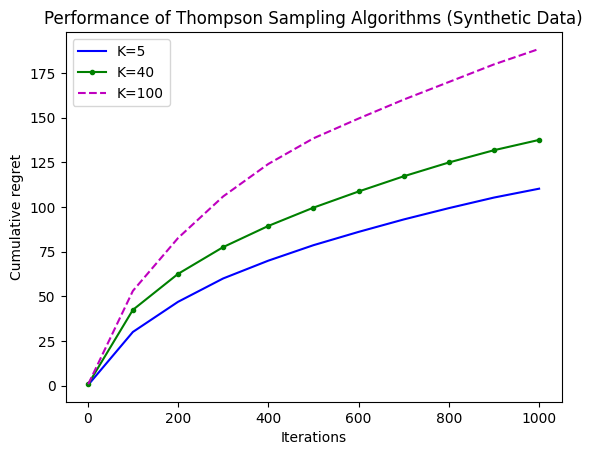

In [ ]:
regret_iteration_denoise_1 = []
regret_iteration_denoise_2 = []
regret_iteration_denoise_3 = []
iterations_list =[1,100,200,300,400,500,600,700,800,900,1000]

for i in iterations_list:
    cumulative_regret_sum = 0
    for n in range(num_experiments):
        cumulative_regret_sum += experiments_regret_denoise_1[n][i-1]
    average_regret = cumulative_regret_sum / num_experiments
    regret_iteration_denoise_1.append(average_regret)

for i in iterations_list:
    cumulative_regret_sum = 0
    for n in range(num_experiments):
        cumulative_regret_sum += experiments_regret_denoise_2[n][i-1]
    average_regret = cumulative_regret_sum / num_experiments
    regret_iteration_denoise_2.append(average_regret)

for i in iterations_list:
    cumulative_regret_sum = 0
    for n in range(num_experiments):
        cumulative_regret_sum += experiments_regret_denoise_3[n][i-1]
    average_regret = cumulative_regret_sum / num_experiments
    regret_iteration_denoise_3.append(average_regret)

print(regret_iteration_denoise_2)
plt.plot(iterations_list, regret_iteration_denoise_1,'b', iterations_list, regret_iteration_denoise_2,'g.-',iterations_list, regret_iteration_denoise_3, 'm--')
plt.legend(['K=5','K=40','K=100'])
plt.xlabel('Iterations')
plt.ylabel('Cumulative regret')
plt.title("Performance of Thompson Sampling Algorithms (Synthetic Data)")
plt.savefig('synresults_TS_13Oct_varyingK_1.png')

In [ ]:
with open('regret_output_13Oct_varyingK_1.txt', 'w') as file:
            file.write(str(iterations_list))
            file.write(str(parameters_1))
            file.write(str(parameters_2))
            file.write(str(parameters_3))
            for item in regret_iteration_denoise_1:
                file.write(f"regret_iteration_denoise_1: {item}\n")
            for item in regret_iteration_denoise_2:
                file.write(f"regret_iteration_denoise_2: {item}\n")
            for item in regret_iteration_denoise_3:
                file.write(f"regret_iteration_denoise_3: {item}\n")


In [ ]:
from google.colab import files
plt.savefig('synresults_TS_13Oct_varyingK.png')
files.download("synresults_TS_13Oct_varyingK.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>